# Image similarity estimation using python - Part II
Siames Network with triplet loss

# Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import datasets
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model


# Hyperparameters

In [ ]:
epochs = 10
batch_size = 16
margin = 1  # Margin for contrastive loss.

# load mnist datase

In [2]:
(x_train_val, y_train_val), (x_test, y_test) = datasets.mnist.load_data()

x_train_val = x_train_val.astype("float32")
x_test = x_test.astype("float32")


11490434/11490434 [==============================] - 2s 0us/step


# Define training and validation sets

In [3]:
# Keep 50% of train_val  in validation set
x_train, x_val = x_train_val[:30000], x_train_val[30000:]
y_train, y_val = y_train_val[:30000], y_train_val[30000:]
del x_train_val, y_train_val

# Create triplet of images
O objetivo de criar triplets de imagem é fazer o modelo diferenciar digitos entre as classes (a == p != n). Por exemplo, 0 == 0 != (1 - 9), 1 == 1 != (0,2 - 9), 2 == 2 != (0,1 - 3-9), etc.

1. selecionar N imagens aleatórias da classe a (ex. digito 0) e pareá-la com N imagens aleatórias da classe p (ex. digito 0) e uma imagem diferente da classe n (por exemplo 3).
2. Repetir etapa (1) para todas as classes (até o digito 9)
3. Repetir etapa (2) para o restante das classes de digitos (1 - 9)

In [4]:
def make_triplets(x, y):
  num_classes = max(y) + 1
  digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

  triplets = []

  for idx1 in range(len(x)):
    a = x[idx1]
    label1 = y[idx1]
    idx2 = random.choice(digit_indices[label1])
    p = x[idx2]

    label2 = random.randint(0, num_classes - 1)
    while label2 == label1:
      label2 = random.randint(0, num_classes - 1)

    idx2 = random.choice(digit_indices[label2])
    n = x[idx2]

    triplets += [[a, p, n]]

  return np.array(triplets)

triplets_train = make_triplets(x_train, y_train)
triplets_val = make_triplets(x_val, y_val)
triplets_test = make_triplets(x_test, y_test)

fake_train_labels = np.zeros((len(y_train), 30)).astype("float32")
fake_val_labels = np.zeros((len(y_val), 30)).astype("float32")
fake_test_labels = np.zeros((len(y_test), 30)).astype("float32")

In [20]:
triplets_test.shape

(10000, 3, 28, 28)

In [19]:
fake_test_labels.shape

(10000, 30)

# Visualize pairs and their labels

In [7]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


### Split the pairs

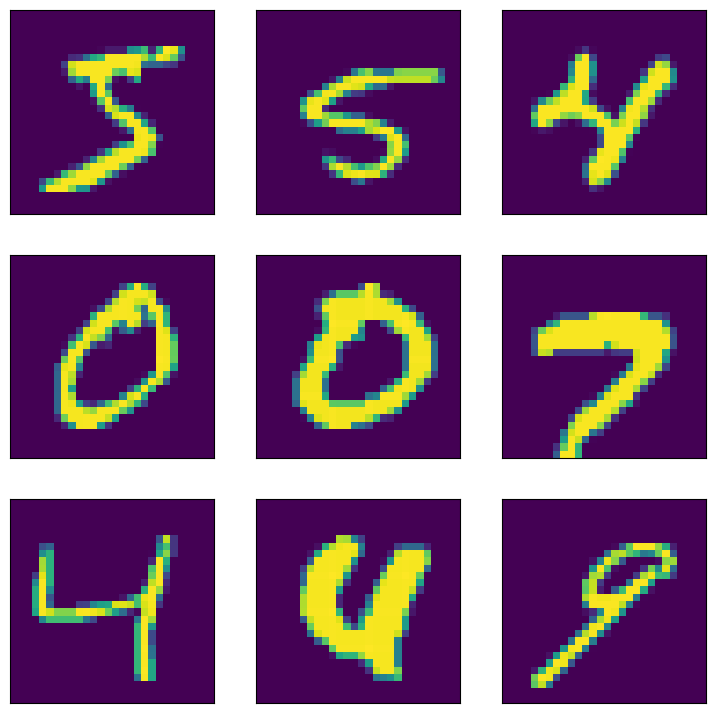

In [8]:
# we can define n_samples
x_train_a = triplets_train[:, 0]
x_train_p = triplets_train[:, 1]
x_train_n = triplets_train[:, 2]
out_train = fake_train_labels[:]

x_val_a = triplets_val[:, 0]
x_val_p = triplets_val[:, 1]
x_val_n = triplets_val[:, 2]
out_val = fake_val_labels[:]

x_test_a = triplets_test[:, 0]
x_test_p = triplets_test[:, 1]
x_test_n = triplets_test[:, 2]
out_test = fake_test_labels[:]

visualize(x_train_a, x_train_p, x_train_n)

# Define triplet loss function

In [10]:
def loss(margin=1):

  def triplet_loss(y_true, y_pred):
    anchor_out = y_pred[:, 0:10]
    positive_out = y_pred[:, 10:20]
    negative_out = y_pred[:, 20:30]

    pos_dist = tf.math.reduce_sum(tf.math.square(positive_out - anchor_out), axis=1)
    neg_dist = tf.math.reduce_sum(tf.math.square(anchor_out - negative_out), axis=1)

    loss = pos_dist - neg_dist
    loss = tf.maximum(loss + margin, 0.0)
    return loss
  return triplet_loss


# Define model
* three inputs layers
* three networks (siamese network)
* embedding network
* merge outputs
* triplet loss

## embedding network

In [11]:
input = layers.Input((28,28,1))
# baseline network
x = layers.BatchNormalization()(input)
x = layers.Conv2D(4, (5,5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(16, (5,5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2,2))(x)
x = layers.Flatten()(x)

x = layers.BatchNormalization()(x)
x = layers.Dense(10, activation="tanh")(x)
embedding_network = Model(input, x)

embedding_network.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 batch_normalization (Batch  (None, 28, 28, 1)         4         
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 24, 24, 4)         104       
                                                                 
 average_pooling2d (Average  (None, 12, 12, 4)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          1616      
                                                                 
 average_pooling2d_1 (Avera  (None, 4, 4, 16)          0     

## siamese network with triplet inputs

In [12]:
input_a = layers.Input((28,28,1))
input_p = layers.Input((28,28,1))
input_n = layers.Input((28,28,1))

# siamese network
# share weights between sisters
tower_a = embedding_network(input_a)
tower_p = embedding_network(input_p)
tower_n = embedding_network(input_n)

merge_layer = layers.Concatenate()([tower_a,tower_p,tower_n])
siamese = Model(inputs=[input_a, input_p, input_n], outputs=merge_layer)
siamese.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 model (Functional)          (None, 10)                   5318      ['input_2[0][0]',             
                                                                     'input_3[0][0]',       

# Compile and train model

In [13]:
siamese.compile(loss=loss(margin=1), optimizer="adam", metrics="mse")

In [21]:
history = siamese.fit(
    [x_train_a, x_train_p, x_train_n],
    out_train,
    validation_data=([x_val_a, x_val_p, x_val_n], out_val),
    batch_size = 16,
    epochs = 10,
)

Epoch 1/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.1494 - mse: 0.6593 - val_loss: 0.0943 - val_mse: 0.7042
Epoch 2/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.1023 - mse: 0.6967 - val_loss: 0.0766 - val_mse: 0.7516
Epoch 3/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0823 - mse: 0.7359 - val_loss: 0.0488 - val_mse: 0.7795
Epoch 4/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0766 - mse: 0.7599 - val_loss: 0.0493 - val_mse: 0.7969
Epoch 5/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0618 - mse: 0.7776 - val_loss: 0.0422 - val_mse: 0.8146
Epoch 6/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0594 - mse: 0.7804 - val_loss: 0.0484 - val_mse: 0.8269
Epoch 7/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0455 - mse: 0.7934 - val_loss: 0.0378 - val_mse: 0.8242
Epoch 8/10
1875/1875 [==============================] 

# Check predictions in test dataset

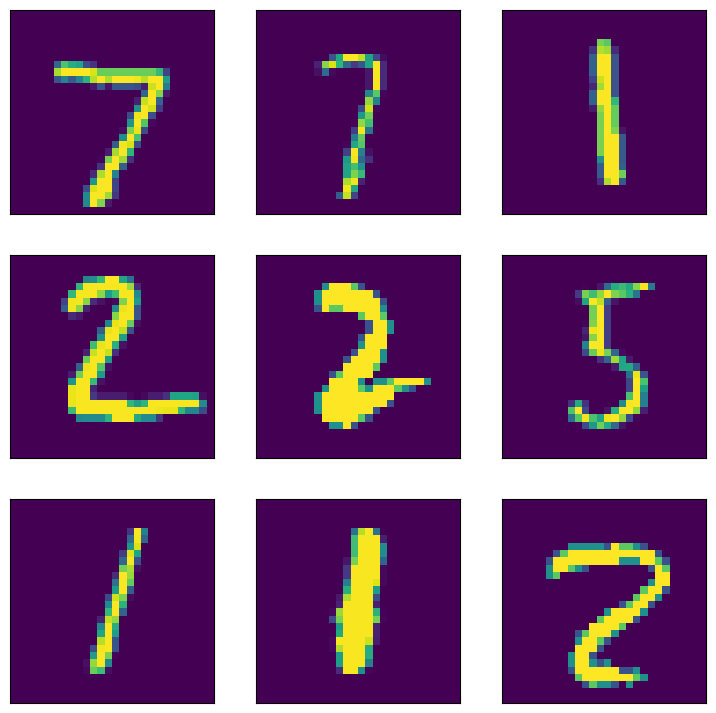

In [22]:
visualize(x_test_a, x_test_p, x_test_n)

In [53]:
def euclidean_distance(vects):
  x, y = vects
  sum_square = tf.math.reduce_sum(tf.math.square(x - y), keepdims=True)
  return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon())) # avoid zero division

In [24]:
anchor_embedding = embedding_network(x_test_a)
positive_embedding = embedding_network(x_test_p)
negative_embedding = embedding_network(x_test_n)

In [62]:
positive_similarity = euclidean_distance([anchor_embedding[30], positive_embedding[30]])
print("Positive distance:", positive_similarity.numpy())

negative_similarity = euclidean_distance([anchor_embedding[30], negative_embedding[30]])
print("Negative distance", negative_similarity.numpy())


Positive distance: [0.14217661]
Negative distance [3.3948178]
